In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

import multiprocessing as mp
import pickle 
import warnings 
warnings.filterwarnings('ignore')

from imports import*
from utils import *
from logistic_regression import *
from rnn import *

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
# num of agent
num_of_agents = 40

# num of block
num_of_block = 3

# num of trials 
num_of_trials = 200

# for cross valdation 
array = np.arange(num_of_block)
cv = [np.roll(array,i) for i in range(num_of_block)]
cv = np.array(cv)


def bce(y_hat,y_true):
    eps = 1e-7
    return -np.sum( y_true*np.log(y_hat+eps) + (1-y_true)*np.log(1-y_hat+eps) )

In [4]:
# upload data
def upload_data(num_of_block,num_of_agents,model):
    all_data = [] 
    for sim in range(1,num_of_block+1):
        data_per_block = []
        for agent in range(1,num_of_agents+1):
            data_per_block.append((pd.read_csv(f'../data/{model}/{model}_agent_{agent}_sim_{sim}.csv')))
        all_data.append(data_per_block)
        
    block_0 = all_data[0]
    block_1 = all_data[1]
    block_2 = all_data[2]

    all_blocks = [block_0,block_1,block_2]

    return all_blocks

In [28]:
def compute_weight_changes_between_states(network_state_t, network_state_t_plus_1):
    """
    Calculate weight changes between two consecutive network states.
    
    Args:
        network_state_t: Network state at time t
        network_state_t_plus_1: Network state at time t+1
        
    Returns:
        numpy.ndarray: Matrix where each row represents flattened weight changes
    """
    weight_changes_list = []
    
    # Iterate through corresponding parameters in both network states
    params_t = dict(network_state_t.named_parameters())
    params_t_plus_1 = dict(network_state_t_plus_1.named_parameters())

    for name in params_t.keys():     
        # Only consider weight matrices, not biases
        if 'weight' in name:
            # Calculate weight difference and convert to numpy
            weight_difference = params_t_plus_1[name].data - params_t[name].data
            # Flatten the weight difference matrix into a vector
            weight_changes_list.append(weight_difference.flatten().cpu().numpy())
            
    # Stack vectors vertically to create weight changes matrix
    return np.concatenate(weight_changes_list)  

def calculate_weight_changes_rank(net, network_states_per_epoch, test_loss):
    """
    Calculate the rank of weight changes matrix around the optimal epoch.
    
    Args:
        net: The trained neural network
        network_states_per_epoch: List of network states from training
        val_loss: Validation loss array from training
        window_size: Number of epochs to consider before and after optimal epoch
        
    Returns:
        tuple: (weight_changes_rank, optimal_epoch_idx)
    """
    # Find optimal epoch based on validation loss
    optimal_epoch_idx = np.argmin(test_loss)
    
    # Consider window_size epochs before and after the optimal epoch
    start_epoch = 0
    end_epoch = min(len(network_states_per_epoch) - 1, optimal_epoch_idx)
    
    network_at_start = GRU_NN(INPUT_SIZE, net.hidden_size, 1, OUTPUT_SIZE).to(device)
    network_at_end = GRU_NN(INPUT_SIZE, net.hidden_size, 1, OUTPUT_SIZE).to(device)
        
    # Load states
    network_at_start.load_state_dict(network_states_per_epoch[start_epoch])
    network_at_end.load_state_dict(network_states_per_epoch[end_epoch])
        
    # Compute weight changes between states
    weight_changes = compute_weight_changes_between_states(
        network_at_start, network_at_end)
    
    # Calculate rank of weight changes matrix
    weight_changes_rank = np.linalg.matrix_rank(weight_changes)
    
    return weight_changes_rank, optimal_epoch_idx

In [6]:
N = num_of_agents

INPUT_SIZE = 4 # 3 for the action (one-hot format) and 1 for the reward of the chosen action
OUTPUT_SIZE = 3 # probabilities of choosing each action in the next trial
LERANING_RATE = 0.001

hidden_size = 5
num_layers = 1
epochs = 1000

In [27]:
def train_rnn_for_model(all_blocks, model):
    loss_train, loss_val, loss_test  = [], [], []
    ll_train, ll_val, ll_test = [], [], []
    ranks, optimal_epochs = [], []

    for n in tqdm(range(N)):
        network_states_per_epoch = []
        for train, val, test in cv:

            train_data = behavior_dataset(all_blocks[train][n])
            val_data = behavior_dataset(all_blocks[val][n])
            test_data = behavior_dataset(all_blocks[test][n])

            train_loader = DataLoader(train_data,shuffle=False,batch_size=len(train_data))
            val_loader = DataLoader(val_data,shuffle=False,batch_size=len(val_data))
            test_loader = DataLoader(test_data,shuffle=False,batch_size=len(test_data))
            
            rnn = GRU_NN(INPUT_SIZE, hidden_size, num_layers, OUTPUT_SIZE)
            rnn, train_loss, train_ll, val_loss, val_ll, test_loss, test_ll, network_states_per_epoch = train_model(rnn,
                                                                                    train_loader,
                                                                                    val_loader,
                                                                                    test_loader,
                                                                                    epochs=epochs,
                                                                                    lr=LERANING_RATE) 
            
            rank, optimal_epoch = calculate_weight_changes_rank(rnn, network_states_per_epoch, test_loss)
                                                                                                                                        
            loss_train.append(train_loss)
            loss_val.append(val_loss)
            loss_test.append(test_loss)
            
            ll_train.append(train_ll)
            ll_val.append(val_ll)
            ll_test.append(test_ll)

            ranks.append(rank)
            optimal_epochs.append(optimal_epoch)
            
        print('Done agent',n)
        
        
    with open(f'../results/{model}_loss_train.pickle', 'wb') as handle:
        pickle.dump(loss_train, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open(f'../results/{model}_loss_val.pickle', 'wb') as handle:
        pickle.dump(loss_val, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open(f'../results/{model}_loss_test.pickle', 'wb') as handle:
        pickle.dump(loss_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open(f'../results/{model}_ll_train.pickle', 'wb') as handle:
        pickle.dump(ll_train, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'../results/{model}_ll_val.pickle', 'wb') as handle:
        pickle.dump(ll_val, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    with open(f'../results/{model}_ll_test.pickle', 'wb') as handle:
        pickle.dump(ll_test, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'../results/{model}_ranks.pickle', 'wb') as handle:
        pickle.dump(ranks, handle, protocol=pickle.HIGHEST_PROTOCOL)

    with open(f'../results/{model}_optimal_epochs.pickle', 'wb') as handle:
        pickle.dump(optimal_epochs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return loss_train, loss_val, loss_test, ll_train, ll_val, ll_test, ranks, optimal_epochs, network_states_per_epoch

In [13]:
def plot_results(model):
    # Load the results from pickle files
    file_paths = {
        "loss_train": f"../results/{model}_loss_train.pickle",
        "loss_val": f"../results/{model}_loss_val.pickle",
        "loss_test": f"../results/{model}_loss_test.pickle",
        "ll_train": f"../results/{model}_ll_train.pickle",
        "ll_val": f"../results/{model}_ll_val.pickle",
        "ll_test": f"../results/{model}_ll_test.pickle",
        # "ranks": f"../results/{model}_ranks.pickle",
        # "optimal_epochs": f"../results/{model}_optimal_epochs.pickle"
    }

    results = {}
    for key, path in file_paths.items():
        with open(path, 'rb') as handle:
            results[key] = pickle.load(handle)

    # Convert lists of lists to averaged lists per epoch
    epochs = len(results["loss_train"][0])  # Assuming all have the same epoch length
    avg_results = {key: [sum(epoch) / len(epoch) for epoch in zip(*values)] for key, values in results.items()}

    # Plotting loss and log-likelihood
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Loss plot
    axes[0].plot(range(epochs), avg_results["loss_train"], label="Train Loss", marker="o")
    axes[0].plot(range(epochs), avg_results["loss_val"], label="Validation Loss", marker="s")
    axes[0].plot(range(epochs), avg_results["loss_test"], label="Test Loss", marker="^")
    axes[0].set_title("Loss Over Epochs")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Log-likelihood plot
    axes[1].plot(range(epochs), avg_results["ll_train"], label="Train Log-Likelihood", marker="o")
    axes[1].plot(range(epochs), avg_results["ll_val"], label="Validation Log-Likelihood", marker="s")
    axes[1].plot(range(epochs), avg_results["ll_test"], label="Test Log-Likelihood", marker="^")
    axes[1].set_title("Log-Likelihood Over Epochs")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Log-Likelihood")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
models = ["none", "exploration_only", "noise_only", "both"]
optimal_epochs_per_model = {}
ranks_per_model = {}
test_losses_per_model = {}
network_states_per_epoch_per_model = {}

for model in models:
    all_blocks = upload_data(num_of_block,num_of_agents,model)
    loss_train, loss_val, loss_test, ll_train, ll_val, ll_test, ranks, optimal_epochs, network_states_per_epoch = train_rnn_for_model(all_blocks, model)
    optimal_epochs_per_model[model] = optimal_epochs
    ranks_per_model[model] = ranks
    test_losses_per_model[model] = loss_test
    network_states_per_epoch_per_model[model] = network_states_per_epoch

  2%|▎         | 1/40 [03:18<2:08:49, 198.19s/it]

Done agent 0


  5%|▌         | 2/40 [06:38<2:06:10, 199.22s/it]

Done agent 1


  8%|▊         | 3/40 [09:53<2:01:50, 197.58s/it]

Done agent 2


 10%|█         | 4/40 [13:00<1:55:58, 193.30s/it]

Done agent 3


 12%|█▎        | 5/40 [16:07<1:51:30, 191.15s/it]

Done agent 4


 15%|█▌        | 6/40 [19:13<1:47:13, 189.23s/it]

Done agent 5


 18%|█▊        | 7/40 [22:20<1:43:38, 188.44s/it]

Done agent 6


 20%|██        | 8/40 [25:25<1:39:59, 187.47s/it]

Done agent 7


 22%|██▎       | 9/40 [28:30<1:36:29, 186.77s/it]

Done agent 8


 25%|██▌       | 10/40 [31:35<1:33:06, 186.22s/it]

Done agent 9


 28%|██▊       | 11/40 [34:40<1:29:47, 185.79s/it]

Done agent 10


 30%|███       | 12/40 [37:45<1:26:35, 185.54s/it]

Done agent 11


 32%|███▎      | 13/40 [40:50<1:23:23, 185.33s/it]

Done agent 12


 35%|███▌      | 14/40 [43:55<1:20:14, 185.18s/it]

Done agent 13


 38%|███▊      | 15/40 [47:00<1:17:06, 185.05s/it]

Done agent 14


 40%|████      | 16/40 [50:05<1:14:04, 185.18s/it]

Done agent 15


 42%|████▎     | 17/40 [53:10<1:11:01, 185.28s/it]

Done agent 16


 45%|████▌     | 18/40 [56:16<1:07:54, 185.21s/it]

Done agent 17


 48%|████▊     | 19/40 [59:22<1:04:54, 185.45s/it]

Done agent 18


 50%|█████     | 20/40 [1:02:29<1:02:02, 186.12s/it]

Done agent 19


 52%|█████▎    | 21/40 [1:05:43<59:39, 188.41s/it]  

Done agent 20


 55%|█████▌    | 22/40 [1:08:53<56:40, 188.94s/it]

Done agent 21


 57%|█████▊    | 23/40 [1:11:55<52:56, 186.85s/it]

Done agent 22


 60%|██████    | 24/40 [1:14:57<49:23, 185.22s/it]

Done agent 23


 62%|██████▎   | 25/40 [1:17:59<46:07, 184.52s/it]

Done agent 24


 65%|██████▌   | 26/40 [1:21:06<43:11, 185.08s/it]

Done agent 25


 68%|██████▊   | 27/40 [1:24:09<40:00, 184.64s/it]

Done agent 26


 70%|███████   | 28/40 [1:27:15<36:57, 184.80s/it]

Done agent 27


 72%|███████▎  | 29/40 [1:30:18<33:49, 184.49s/it]

Done agent 28


 75%|███████▌  | 30/40 [1:33:23<30:45, 184.57s/it]

Done agent 29


 78%|███████▊  | 31/40 [1:36:35<28:00, 186.69s/it]

Done agent 30


 80%|████████  | 32/40 [1:39:46<25:04, 188.08s/it]

Done agent 31


 82%|████████▎ | 33/40 [1:43:01<22:10, 190.12s/it]

Done agent 32


 85%|████████▌ | 34/40 [1:46:12<19:01, 190.32s/it]

Done agent 33


 88%|████████▊ | 35/40 [1:49:25<15:55, 191.06s/it]

Done agent 34


 90%|█████████ | 36/40 [1:52:37<12:46, 191.62s/it]

Done agent 35


 92%|█████████▎| 37/40 [1:55:49<09:34, 191.52s/it]

Done agent 36


 95%|█████████▌| 38/40 [1:59:01<06:23, 191.70s/it]

Done agent 37


 98%|█████████▊| 39/40 [2:02:11<03:11, 191.37s/it]

Done agent 38


100%|██████████| 40/40 [2:05:25<00:00, 188.15s/it]

Done agent 39



  2%|▎         | 1/40 [03:10<2:03:55, 190.65s/it]

Done agent 0


  5%|▌         | 2/40 [06:26<2:02:36, 193.60s/it]

Done agent 1


  8%|▊         | 3/40 [09:43<2:00:19, 195.12s/it]

Done agent 2


 10%|█         | 4/40 [13:04<1:58:32, 197.57s/it]

Done agent 3


 12%|█▎        | 5/40 [16:27<1:56:17, 199.35s/it]

Done agent 4


 15%|█▌        | 6/40 [19:37<1:51:14, 196.32s/it]

Done agent 5


 18%|█▊        | 7/40 [22:52<1:47:39, 195.74s/it]

Done agent 6


 20%|██        | 8/40 [26:00<1:43:11, 193.47s/it]

Done agent 7


 22%|██▎       | 9/40 [29:14<1:40:01, 193.59s/it]

Done agent 8


 25%|██▌       | 10/40 [32:30<1:37:11, 194.40s/it]

Done agent 9


 28%|██▊       | 11/40 [35:43<1:33:42, 193.88s/it]

Done agent 10


 30%|███       | 12/40 [38:56<1:30:18, 193.50s/it]

Done agent 11


 32%|███▎      | 13/40 [42:07<1:26:44, 192.75s/it]

Done agent 12


 35%|███▌      | 14/40 [45:17<1:23:15, 192.12s/it]

Done agent 13


 38%|███▊      | 15/40 [48:27<1:19:42, 191.31s/it]

Done agent 14


 40%|████      | 16/40 [51:35<1:16:12, 190.51s/it]

Done agent 15


 42%|████▎     | 17/40 [54:47<1:13:07, 190.75s/it]

Done agent 16


 45%|████▌     | 18/40 [58:01<1:10:21, 191.90s/it]

Done agent 17


 48%|████▊     | 19/40 [1:01:14<1:07:13, 192.05s/it]

Done agent 18


 50%|█████     | 20/40 [1:04:26<1:04:05, 192.27s/it]

Done agent 19


 52%|█████▎    | 21/40 [1:07:39<1:00:55, 192.37s/it]

Done agent 20


 55%|█████▌    | 22/40 [1:10:56<58:05, 193.62s/it]  

Done agent 21


 57%|█████▊    | 23/40 [1:14:08<54:47, 193.36s/it]

Done agent 22


 60%|██████    | 24/40 [1:17:17<51:13, 192.07s/it]

Done agent 23


 62%|██████▎   | 25/40 [1:20:33<48:15, 193.02s/it]

Done agent 24


 65%|██████▌   | 26/40 [1:23:46<45:04, 193.14s/it]

Done agent 25


 68%|██████▊   | 27/40 [1:26:59<41:50, 193.12s/it]

Done agent 26


 70%|███████   | 28/40 [1:30:10<38:29, 192.47s/it]

Done agent 27


 72%|███████▎  | 29/40 [1:33:24<35:23, 193.03s/it]

Done agent 28


 75%|███████▌  | 30/40 [1:36:36<32:06, 192.61s/it]

Done agent 29


 78%|███████▊  | 31/40 [1:39:49<28:53, 192.58s/it]

Done agent 30


 80%|████████  | 32/40 [1:43:02<25:43, 192.96s/it]

Done agent 31


 82%|████████▎ | 33/40 [1:46:19<22:39, 194.17s/it]

Done agent 32


 85%|████████▌ | 34/40 [1:49:35<19:28, 194.73s/it]

Done agent 33


 88%|████████▊ | 35/40 [1:52:50<16:13, 194.69s/it]

Done agent 34


 90%|█████████ | 36/40 [1:56:04<12:58, 194.59s/it]

Done agent 35


 92%|█████████▎| 37/40 [1:59:18<09:43, 194.33s/it]

Done agent 36


 95%|█████████▌| 38/40 [2:02:35<06:30, 195.04s/it]

Done agent 37


 98%|█████████▊| 39/40 [2:05:52<03:15, 195.74s/it]

Done agent 38


100%|██████████| 40/40 [2:09:08<00:00, 193.72s/it]

Done agent 39



  2%|▎         | 1/40 [03:11<2:04:25, 191.43s/it]

Done agent 0


  5%|▌         | 2/40 [06:22<2:00:58, 191.02s/it]

Done agent 1


  8%|▊         | 3/40 [09:34<1:58:17, 191.84s/it]

Done agent 2


 10%|█         | 4/40 [12:36<1:52:33, 187.59s/it]

Done agent 3


 12%|█▎        | 5/40 [15:41<1:48:52, 186.65s/it]

Done agent 4


 15%|█▌        | 6/40 [18:44<1:45:07, 185.52s/it]

Done agent 5


 18%|█▊        | 7/40 [21:47<1:41:37, 184.76s/it]

Done agent 6


 20%|██        | 8/40 [24:50<1:38:15, 184.25s/it]

Done agent 7


 22%|██▎       | 9/40 [27:53<1:35:01, 183.92s/it]

Done agent 8


 25%|██▌       | 10/40 [30:57<1:31:49, 183.67s/it]

Done agent 9


 28%|██▊       | 11/40 [33:59<1:28:40, 183.46s/it]

Done agent 10


 30%|███       | 12/40 [37:00<1:25:15, 182.69s/it]

Done agent 11


 32%|███▎      | 13/40 [40:01<1:21:55, 182.05s/it]

Done agent 12


 35%|███▌      | 14/40 [43:01<1:18:40, 181.55s/it]

Done agent 13


 38%|███▊      | 15/40 [46:02<1:15:32, 181.32s/it]

Done agent 14


 40%|████      | 16/40 [49:02<1:12:23, 180.99s/it]

Done agent 15


 42%|████▎     | 17/40 [52:03<1:09:19, 180.86s/it]

Done agent 16


 45%|████▌     | 18/40 [55:04<1:06:18, 180.85s/it]

Done agent 17


 48%|████▊     | 19/40 [58:04<1:03:13, 180.65s/it]

Done agent 18


 50%|█████     | 20/40 [1:01:05<1:00:17, 180.87s/it]

Done agent 19


 52%|█████▎    | 21/40 [1:04:06<57:17, 180.94s/it]  

Done agent 20


 55%|█████▌    | 22/40 [1:07:07<54:12, 180.67s/it]

Done agent 21


 57%|█████▊    | 23/40 [1:10:07<51:09, 180.57s/it]

Done agent 22


 60%|██████    | 24/40 [1:13:07<48:08, 180.54s/it]

Done agent 23


 62%|██████▎   | 25/40 [1:16:08<45:07, 180.49s/it]

Done agent 24


 65%|██████▌   | 26/40 [1:19:08<42:05, 180.38s/it]

Done agent 25


 68%|██████▊   | 27/40 [1:22:08<39:02, 180.22s/it]

Done agent 26


 70%|███████   | 28/40 [1:25:08<36:01, 180.16s/it]

Done agent 27


 72%|███████▎  | 29/40 [1:28:08<33:01, 180.14s/it]

Done agent 28


 75%|███████▌  | 30/40 [1:31:09<30:03, 180.34s/it]

Done agent 29


 78%|███████▊  | 31/40 [1:34:09<27:04, 180.50s/it]

Done agent 30


 80%|████████  | 32/40 [1:37:15<24:15, 181.88s/it]

Done agent 31


 82%|████████▎ | 33/40 [1:40:18<21:16, 182.42s/it]

Done agent 32


 85%|████████▌ | 34/40 [1:43:23<18:18, 183.02s/it]

Done agent 33


 88%|████████▊ | 35/40 [1:46:27<15:16, 183.39s/it]

Done agent 34


 90%|█████████ | 36/40 [1:49:31<12:14, 183.63s/it]

Done agent 35


 92%|█████████▎| 37/40 [1:52:35<09:11, 183.78s/it]

Done agent 36


 95%|█████████▌| 38/40 [1:55:40<06:08, 184.01s/it]

Done agent 37


 98%|█████████▊| 39/40 [1:58:44<03:04, 184.14s/it]

Done agent 38


100%|██████████| 40/40 [2:01:49<00:00, 182.73s/it]

Done agent 39



  2%|▎         | 1/40 [03:04<2:00:01, 184.65s/it]

Done agent 0


  5%|▌         | 2/40 [06:09<1:56:58, 184.69s/it]

Done agent 1


  8%|▊         | 3/40 [09:15<1:54:13, 185.22s/it]

Done agent 2


 10%|█         | 4/40 [12:31<1:53:44, 189.57s/it]

Done agent 3


 12%|█▎        | 5/40 [15:50<1:52:38, 193.11s/it]

Done agent 4


 15%|█▌        | 6/40 [19:08<1:50:13, 194.52s/it]

Done agent 5


 18%|█▊        | 7/40 [22:26<1:47:46, 195.94s/it]

Done agent 6


 20%|██        | 8/40 [25:46<1:45:10, 197.21s/it]

Done agent 7


 22%|██▎       | 9/40 [29:03<1:41:50, 197.10s/it]

Done agent 8


 25%|██▌       | 10/40 [32:20<1:38:31, 197.05s/it]

Done agent 9


 28%|██▊       | 11/40 [35:39<1:35:26, 197.46s/it]

Done agent 10


 30%|███       | 12/40 [38:58<1:32:23, 197.98s/it]

Done agent 11


 32%|███▎      | 13/40 [42:18<1:29:20, 198.56s/it]

Done agent 12


 35%|███▌      | 14/40 [45:33<1:25:40, 197.70s/it]

Done agent 13


 38%|███▊      | 15/40 [48:51<1:22:24, 197.79s/it]

Done agent 14


 40%|████      | 16/40 [52:10<1:19:11, 197.98s/it]

Done agent 15


 42%|████▎     | 17/40 [55:30<1:16:07, 198.59s/it]

Done agent 16


 45%|████▌     | 18/40 [58:44<1:12:20, 197.31s/it]

Done agent 17


 48%|████▊     | 19/40 [1:01:58<1:08:39, 196.18s/it]

Done agent 18


 50%|█████     | 20/40 [1:05:11<1:05:07, 195.37s/it]

Done agent 19


 52%|█████▎    | 21/40 [1:08:24<1:01:39, 194.72s/it]

Done agent 20


 55%|█████▌    | 22/40 [1:11:38<58:17, 194.31s/it]  

Done agent 21


 57%|█████▊    | 23/40 [1:14:50<54:53, 193.73s/it]

Done agent 22


 60%|██████    | 24/40 [1:18:03<51:36, 193.55s/it]

Done agent 23


 62%|██████▎   | 25/40 [1:21:16<48:20, 193.38s/it]

Done agent 24


 65%|██████▌   | 26/40 [1:24:28<45:02, 193.01s/it]

Done agent 25


 68%|██████▊   | 27/40 [1:27:42<41:51, 193.18s/it]

Done agent 26


 70%|███████   | 28/40 [1:30:54<38:34, 192.90s/it]

Done agent 27


 72%|███████▎  | 29/40 [1:34:08<35:23, 193.06s/it]

Done agent 28


 75%|███████▌  | 30/40 [1:37:20<32:08, 192.83s/it]

Done agent 29


 78%|███████▊  | 31/40 [1:40:34<28:59, 193.25s/it]

Done agent 30


 80%|████████  | 32/40 [1:43:48<25:47, 193.46s/it]

Done agent 31


 82%|████████▎ | 33/40 [1:47:02<22:36, 193.74s/it]

Done agent 32


 85%|████████▌ | 34/40 [1:50:15<19:20, 193.41s/it]

Done agent 33


 88%|████████▊ | 35/40 [1:53:27<16:05, 193.01s/it]

Done agent 34


 90%|█████████ | 36/40 [1:56:41<12:52, 193.20s/it]

Done agent 35


 92%|█████████▎| 37/40 [1:59:53<09:38, 192.86s/it]

Done agent 36


 95%|█████████▌| 38/40 [2:03:06<06:26, 193.02s/it]

Done agent 37


 98%|█████████▊| 39/40 [2:06:20<03:13, 193.10s/it]

Done agent 38


100%|██████████| 40/40 [2:09:33<00:00, 194.34s/it]

Done agent 39


none


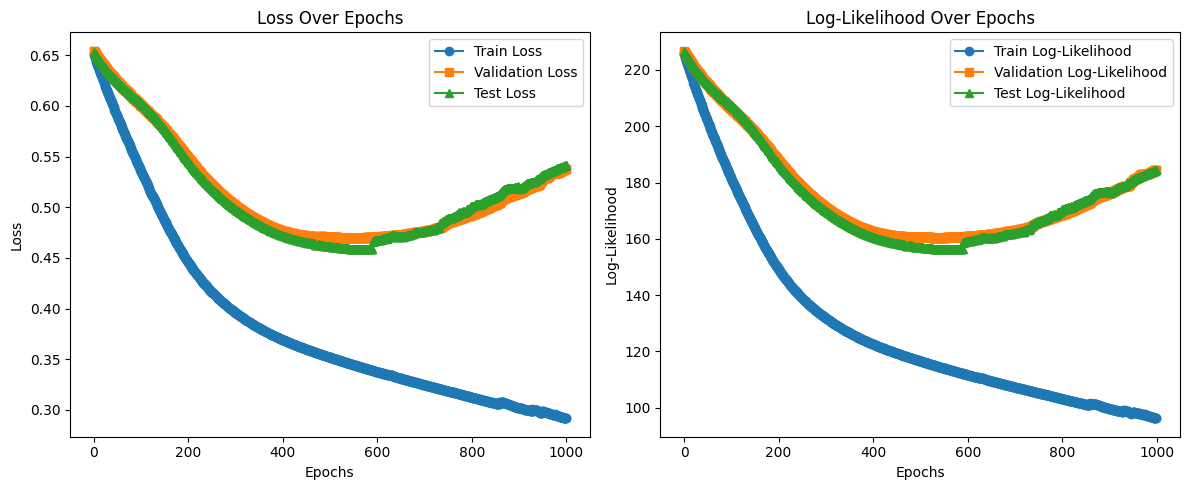

exploration_only


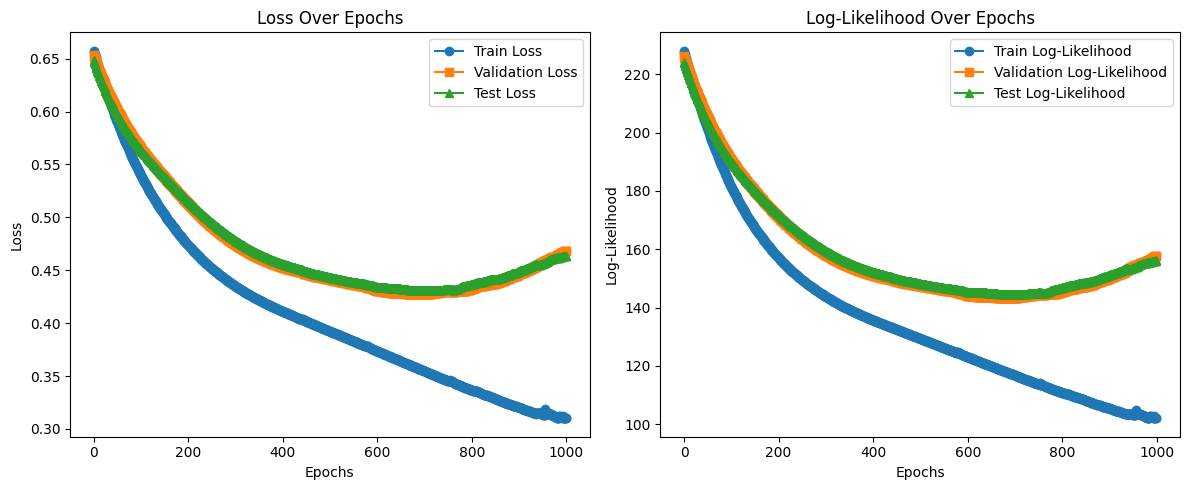

noise_only


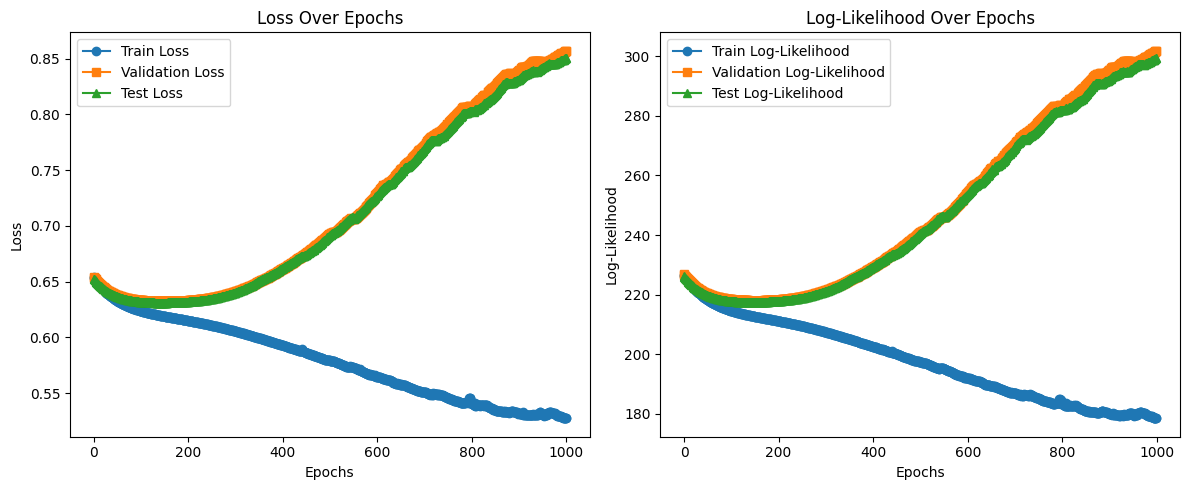

both


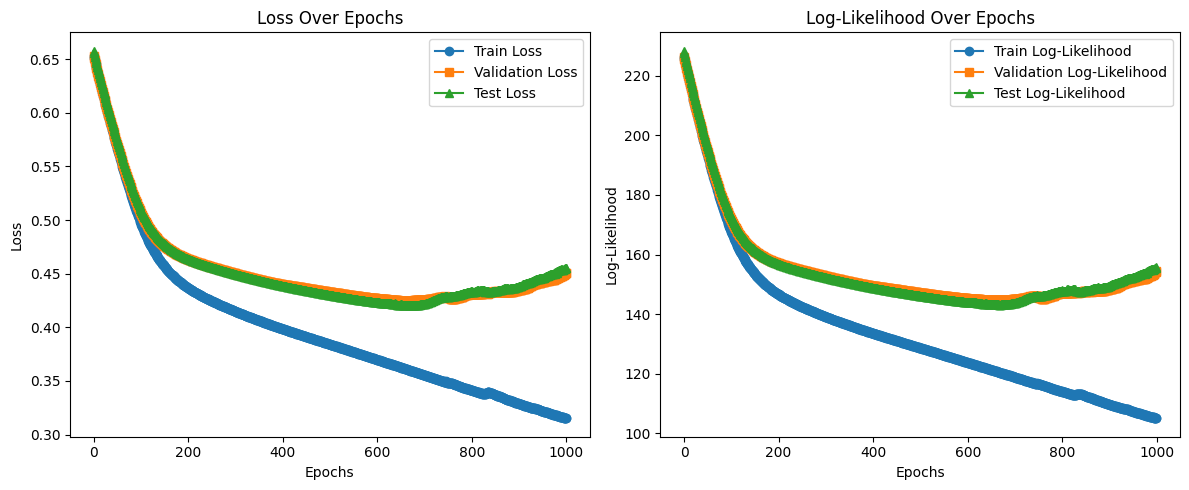

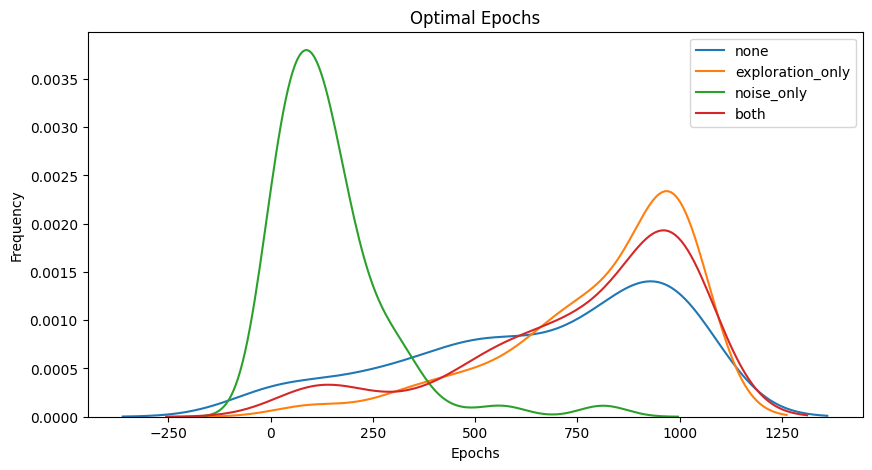

AttributeError: Rectangle.set() got an unexpected keyword argument 'kde'

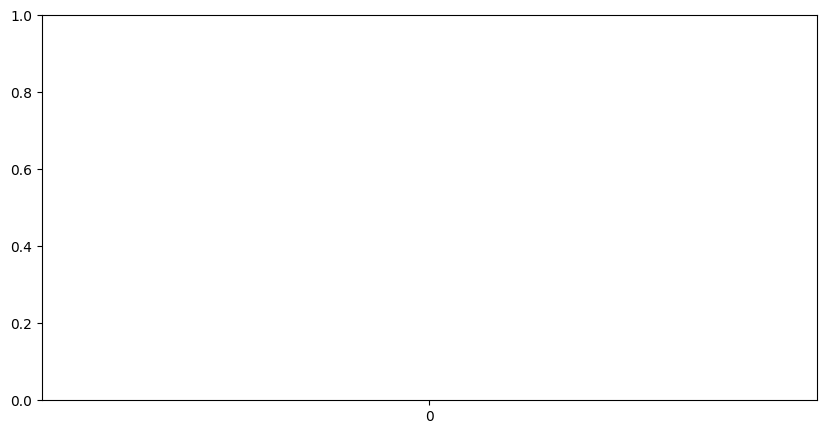

In [17]:
# The bug was in plot resutls, I fixed it but I moved it to a new loop and code block so that all of the data will be saved before we procceed
for model in models:
    print(model)
    plot_results(model)

#plot optimal epochs by model
fig, ax = plt.subplots(figsize=(10, 5))
for model, optimal_epochs in optimal_epochs_per_model.items():
    sns.kdeplot(data=optimal_epochs, label=model, ax=ax)
ax.set_title("Optimal Epochs")
ax.set_xlabel("Epochs")
ax.set_ylabel("Frequency")
plt.legend()
plt.show()

#plot ranks by model
fig, ax = plt.subplots(figsize=(10, 5))
for model, ranks in ranks_per_model.items():
    sns.barplot(ranks, kde=True, label=model, ax=ax)
ax.set_title("Rank of Weight Changes Matrix Around Optimal Epoch")
ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")
plt.legend()
plt.show()

#plot test losses by epoch, grouped by model
# fig, ax = plt.subplots(figsize=(10, 5))
# for model, test_losses in test_losses_per_model.items():
#     for test_loss in test_losses:
#         ax.plot(range(len(test_loss)), test_loss, label=model)
# ax.set_title("Test Loss Over Epochs")
